In [1]:
import json
from scipy.io import wavfile as wav
from statsmodels.tsa.stattools import adfuller, kpss
import gpytorch
import torch
import GPy
import math
import numpy
import os
import warnings
import matrixprofile as mp
from tqdm import tqdm

%pylab inline
#figsize(15, 5)

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
Populating the interactive namespace from numpy and matplotlib


# MIDI processor class

Find segments where a new note has not been played in the last 300ms, while there are still active notes (key not released).

In [2]:
import pandas as pd
import mido

# 13230 data points equates to 300ms of audio when sampling at 44kHz
stationary_length = 13230
ms100 = 4410

class MidiProcessor():
    def __init__(self, filename):
        self.pedal_active = False
        self.stationary = []
        self.delta = 0
        self.tempo = 500000
        self.beats_per_seconds = 1000000 / self.tempo
        self.notes_playing = []
        self.total_ticks = 0
        self.datapoints = []
        self.find_stationary_segments(filename)
        
    def ticks_to_ms(self, ticks):
        beats = ticks / self.ticks_per_beat
        seconds = beats / self.beats_per_seconds
        msec = seconds * 1000.
        return msec
    
    def is_pedal(self, control):
        sustain = control == 64
        soft = control == 67
        return sustain or soft
    
    def add_to_delta(self, time):
        self.delta += time
    
    def process_pedal(self, value):
        self.pedal_active = True if value >= 64 else False
        
    def process_note_on(self, note_on):
        note = note_on.note
        velocity = note_on.velocity
        time = note_on.time
        
        if velocity == 0:
            self.add_to_delta(time)
            if note in self.notes_playing:
                self.notes_playing.remove(note)
        else:
            self.delta = 0
            self.new_segment = True
            if self.pedal_active == True:
                self.notes_playing.append(note)
        
    def process_change(self, change):
        control = change.control
        value = change.value
        time = change.time
        
        if self.is_pedal(control):
            self.process_pedal(value)
      
        self.add_to_delta(time)
        
    # 13230 data points corresponds to 300ms
    # So if we want to get to index 13230 with a value of 300 as input, we multiply 300 by 13230 / 300
    def time_to_index(self, time):
        factor = stationary_length / 300
        index = time * factor
        return index
        
    def add_current_position(self):
        elapsed_time = self.ticks_to_ms(self.total_ticks)
        index = round(self.time_to_index(elapsed_time))
        self.stationary.append(elapsed_time)
        self.datapoints.append(index)
        
    def check_length(self):
        if self.ticks_to_ms(self.delta) > 300:
            is_silence = not self.notes_playing
            if not is_silence and self.new_segment:
                self.add_current_position()
                self.new_segment = False
        
    def find_stationary_segments(self, filename):
        midi = mido.MidiFile(filename)
        meta_track = midi.tracks[0]
        sound_track = midi.tracks[1]
        
        self.ticks_per_beat = midi.ticks_per_beat
        
        for msg in sound_track:
            msg_type = msg.type
            self.total_ticks += msg.time
            
            is_note_on = msg_type == "note_on"
            is_control_change = msg_type == "control_change"
            if is_note_on:
                self.process_note_on(msg)
            elif is_control_change:
                self.process_change(msg)
                
            self.check_length()
            
        return self.datapoints

# Using the dataset metadata

In [3]:
with open("../data/maestro/maestro-v3.0.0.json", 'r') as file:
    data = json.load(file)
    
composers = data["canonical_composer"]
pieces = data["canonical_title"]
filenames = data["audio_filename"]

info = {}

for i in range(len(filenames)):
    i = str(i)
    composer = composers[i]
    piece = pieces[i]
    filename = filenames[i][5:-4]
    
    info[filename] = {"composer": composer, "piece": piece, "filenumber": i}

# Iteration over all MIDI files

In [4]:
import random

segments = {}
count = 0

folder = "../data/maestro/"
for f in os.walk(folder):
    f_name = f[0]
    if count == 2:
        break
    if f_name is not folder:
        performances = list(filter(lambda name : name.endswith('midi'), f[2]))
        for performance in tqdm(performances):
            full_filename = f_name + "/" + performance
            ss = MidiProcessor(full_filename).datapoints
            random.shuffle(ss)
            
            file_info = info[performance[:-5]]
            key = ":".join([file_info["composer"], file_info["piece"]])
            
            if key not in segments:
                segments[key] = []
            
            for segment in ss:
                value = ":".join([file_info["filenumber"], str(segment)])
                segments[key].append(value)
                
    count += 1

100%|████████████████████████████████████████| 132/132 [01:02<00:00,  2.10it/s]


# Saving and retrieving segments

In [5]:
with open("segments.json", "w") as file:
    json.dump(segments, file)

In [6]:
with open("segments.json", "r") as file:
    segments = json.load(file)

# Sampling

In [7]:
class Sampler():
    def __init__(self, dataset):
        self.dataset = dataset
        self.samples = []
        
    def take_sample(self, key):
        sample = random.sample(self.dataset[key], 1)
        if sample in self.samples:
            self.take_sample(key)
        else:
            self.samples.append(sample)
        
    def take_n_samples(self, N):
        segment_amount = len(self.dataset.values())
        
        for key in self.dataset:
            segments_for_key = self.dataset[key]
            segments_for_key_amount = len(segments_for_key)
            
            percentage = segments_for_key_amount / segment_amount
            amount_to_take_for_key = int(floor(percentage))
            
            for i in range(amount_to_take_for_key):
                self.take_sample(key)
                
sampler = Sampler(segments)
sampler.take_n_samples(100)

In [8]:
print(len(sampler.samples))

154


# Class for segment

In [9]:
from IPython.display import Audio
from IPython.core.display import display

SHORT = 220
MEDIUM = 2200
LONG = 4400

class Segment():
    def __init__(self, identifier):
        self.filenumber, self.end = self.extract_from_identifier(identifier)    
        self.end = int(self.end)
        self.start = self.end - stationary_length
        
        self.filename = self.get_filename()
        self.data = self.get_data()
        self.play()
        
    def extract_from_identifier(self, identifier):
        return identifier[0].split(":")
    
    def get_filename(self):
        return data["audio_filename"][self.filenumber]
    
    def get_data(self):
        root = "../data/maestro/"
        self.rate, wav_data = wav.read(root + self.filename)
        wav_data = wav_data / amax(abs(wav_data))
        wav_data -= mean(wav_data)
        wav_data = wav_data[self.start:self.end, :]
        return wav_data
    
    def show_segment(self):
        plot(self.data[:6600, 0])
        show()
        plot(self.data[:6600, 1], color="purple")
        show()
        
    def play(self):
        left_channel = self.data[:, 0]
        right_channel = self.data[:, 1]
        
        display(Audio([left_channel, right_channel], rate=self.rate, autoplay=True))
        
seg = Segment(sampler.samples[5])

In [10]:
import PIL
import io
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

class Spectrogram():
    def __init__(self, data, part):
        self.left_channel = data[:, 0]
        self.right_channel = data[:, 1]
        self.part = part
        
        self.save_file = self.calculate()
    
    def calculate(self):
        fig = Figure()
        gs = fig.add_gridspec(2, hspace=0)
        axs = gs.subplots(sharex=True, sharey=True)
        axs[0].specgram(self.left_channel, Fs=44100)
        axs[0].axis('off')
        axs[1].specgram(self.right_channel, Fs=44100)
        axs[1].axis('off')
        fig.tight_layout()
        filename = "parts/segment_part" + str(self.part) + ".png"
        fig.savefig(filename)
        return filename

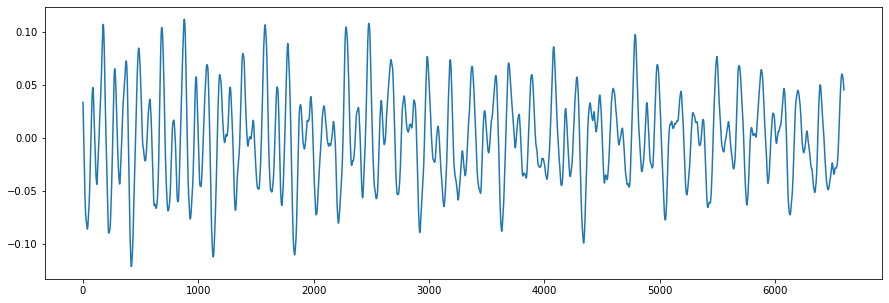

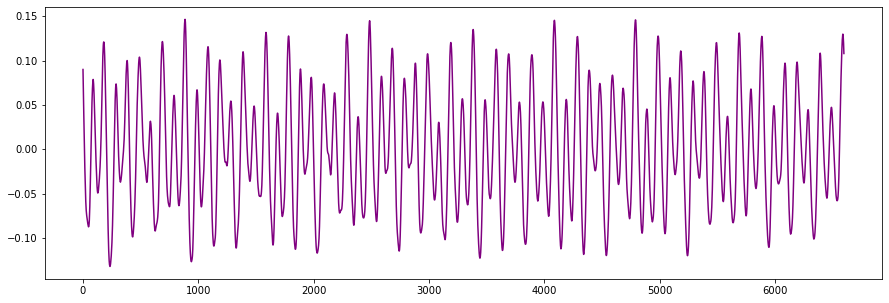

 C:\Users\Nick\Anaconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning:savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later


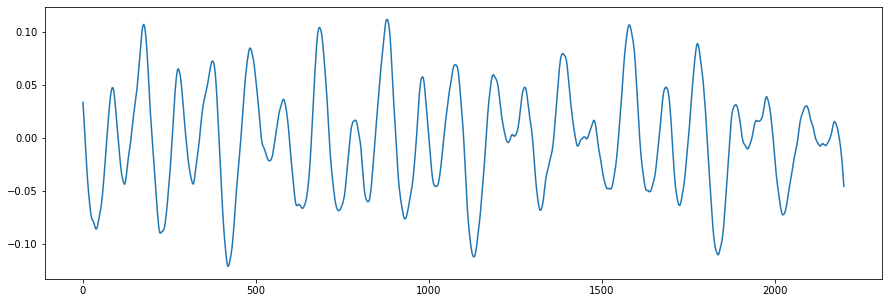

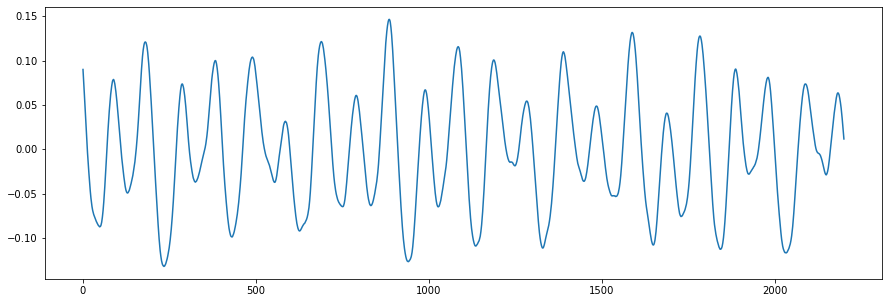

 C:\Users\Nick\Anaconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning:savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later


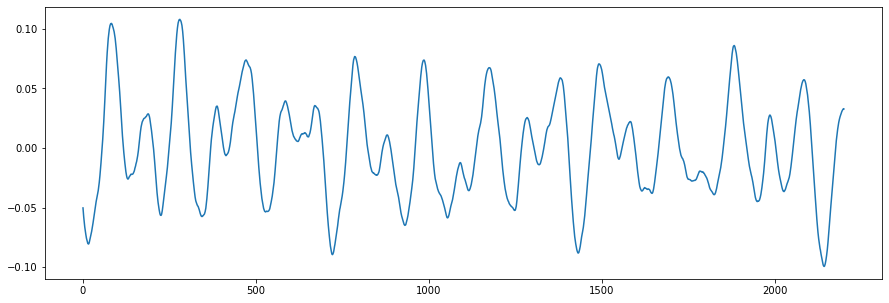

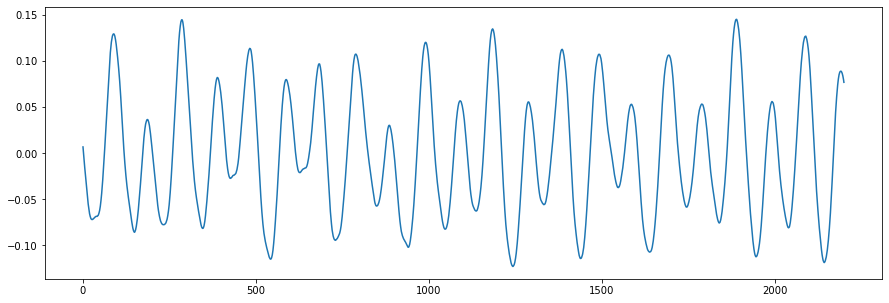

 C:\Users\Nick\Anaconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning:savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later


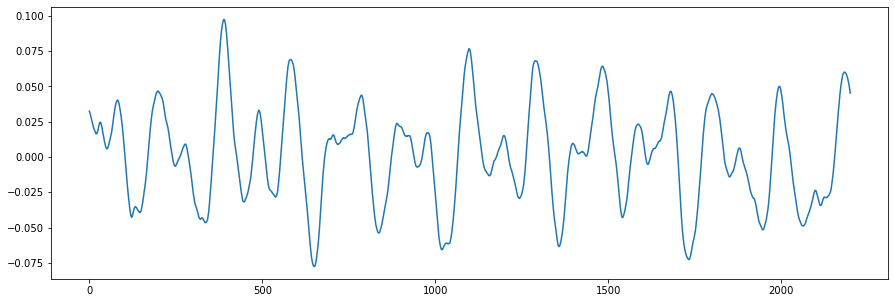

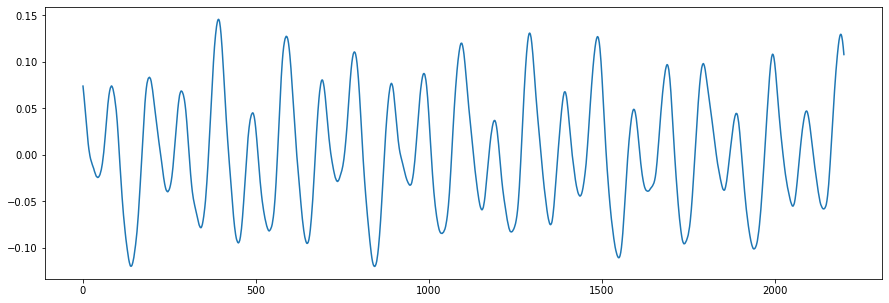

0.08600000000000001
-2.453407982728629


AssertionError: 

In [13]:
import cv2
from pathlib import Path

class Validator():
    def __init__(self, segment, surrounding_length, gap_length):
        self.segment = segment
        self.surrounding_length = surrounding_length
        self.gap_length = gap_length
        self.smallest_length = min(surrounding_length, gap_length)
        
        self.specs = []
        self.frames()
        
    def make_frame(self, start, part):
        end = start + self.smallest_length
        frame_data = self.segment[start:end,:]
        frame = Spectrogram(frame_data, part)
        self.specs.append(frame)
        plot(frame_data[:,0])
        show()
        plot(frame_data[:,1])
        show()
        
    def split_equally(self, parts):
        for i in range(parts):
            frame_start = i * self.smallest_length
            frame = self.make_frame(frame_start, i)
    
    def frames(self):
        if self.surrounding_length == self.gap_length:
            total_parts = 3
        elif self.surrounding_length < self.gap_length:
            gap_parts = int(self.gap_length / self.surrounding_length)
            total_parts = gap_parts + 2
        elif self.gap_length < self.surrounding_length:
            surrounding_parts = int(self.surrounding_length / self.gap_length)
            total_parts = 2 * surrounding_parts + 1
           
        self.split_equally(total_parts)
        
    def save_to_video(self):
        self.file_path = "parts/ex.mp4"
        fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
        writer = cv2.VideoWriter(self.file_path, fourcc, 30, (432, 288))
        for spec in self.specs:
            file = spec.save_file
            frame = cv2.imread(file)
            writer.write(frame)
            
        writer.release()
        
    def retrieve_metric_value(self, log_value):
        assert log_value > 0
        metric_value = "Not stationary"
        if log_value <= 3:
            metric_value = "Not very stationary"
        if log_value <= 2.5:
            metric_value = "Stationary"
        if log_value <= 2:
            metric_value = "Very stationary"
        if log_value <= 1.5:
            metric_value = "Extremely stationary"
            
        return metric_value
        
    def check_validity(self):
        video_size = Path(self.file_path).stat().st_size
        size_in_kb = video_size / 1000       
        frames = len(self.specs)
        kb_per_frame = size_in_kb / frames
        log_value = log(kb_per_frame)
        print(kb_per_frame)
        print(log_value)
        
        return self.retrieve_metric_value(log_value)

seg = Segment(sampler.samples[0])
seg.show_segment()
val = Validator(seg.data, MEDIUM, MEDIUM)
val.save_to_video()
validity = val.check_validity()
print(validity)
figsize(15,5)
seg.show_segment()